# Prepared data for Analysis

## Imported data and loaded in dataframe

In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.preprocessing import *
from sklearn.model_selection import cross_val_score
import statsmodels.api as sm
import scipy.stats as stats
from statsmodels.stats.outliers_influence import variance_inflation_factor
import pylab 
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

path = '../../../data/kc_housing_data.csv'
all_data = pd.read_csv('https://raw.githubusercontent.com/learn-co-students/bsc-phase-two-project/main/data/kc_house_data.csv')

In [40]:
all_data

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,0.0,...,7,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,...,7,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,0.0,0.0,...,6,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,...,7,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,...,8,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21592,263000018,5/21/2014,360000.0,3,2.50,1530,1131,3.0,0.0,0.0,...,8,1530,0.0,2009,0.0,98103,47.6993,-122.346,1530,1509
21593,6600060120,2/23/2015,400000.0,4,2.50,2310,5813,2.0,0.0,0.0,...,8,2310,0.0,2014,0.0,98146,47.5107,-122.362,1830,7200
21594,1523300141,6/23/2014,402101.0,2,0.75,1020,1350,2.0,0.0,0.0,...,7,1020,0.0,2009,0.0,98144,47.5944,-122.299,1020,2007
21595,291310100,1/16/2015,400000.0,3,2.50,1600,2388,2.0,NaN,0.0,...,8,1600,0.0,2004,0.0,98027,47.5345,-122.069,1410,1287


## Created a map of the area

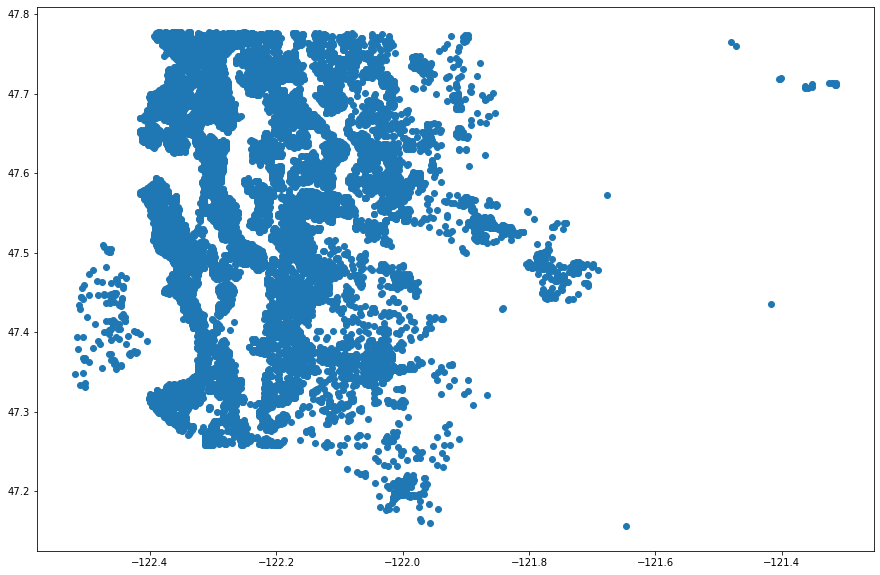

In [41]:
fig, ax = plt.subplots(figsize=(15,10))
ax.scatter(x='long', y='lat', data=all_data)

In [42]:
all_data.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15'],
      dtype='object')

# Creating new variables

## Added Age and Cleaned Columns

In [43]:
df = all_data.drop(['view', 'zipcode', 'lat', 'long', 'sqft_above', 'sqft_living15', 'sqft_lot15'], axis=1)

In [44]:
yrs = [int(x[-4:]) for x in df['date']]
df['date'] = yrs

In [45]:
for x in range(len(df)):
    if df['yr_renovated'][x] == True:
        if df['yr_renovated'][x] > 0:
            df['yr_built'][x] = df['yr_renovated'][x]

In [46]:
df['renovated'] = [int(x) for x in (df['yr_renovated'] > 0)]

In [47]:
df['yr_renovated/built'] = df['yr_built']

In [48]:
df['age'] = df['date'] - df['yr_renovated/built']

In [49]:
df.drop(['yr_renovated','yr_built', 'date'], axis=1, inplace=True)

## One-Hot Encoded Basement

In [50]:
df['sqft_basement'] = df['sqft_basement'].fillna(0)
df['sqft_basement'] = df['sqft_basement'].str.replace('?', '0')
df['sqft_basement'] = df['sqft_basement'].astype(float)
df['has_basement'] = [int(x) for x in df['sqft_basement'] > 0]
df = df.drop('sqft_basement', axis=1)

## Created new groups for region, and made DataFrames for country and Seattle Areas

In [51]:
df['region'] = [int(x) for x in all_data['long'] > -121.95]

In [52]:
df_country = df.loc[df['region']==1]
df_seattle = df.loc[df['region']==0]

# Test models to see what is a good variable

In [53]:
X = sm.add_constant(df[['sqft_living', 'floors', 'grade', 'age']])
y = df['price']
model_1 = sm.OLS(y, X)
results = model_1.fit()

In [54]:
X = df[['sqft_living', 'floors', 'grade', 'age']]

In [55]:
residuals = results.resid

In [56]:
preds = results.predict()

# Making a Function to check assumptions

In [57]:
def check_model(model, X, y):
    results = model.fit()
    residuals = results.resid
    preds = results.predict()
        
    display(rainbow(results), vif(X), heteroskd(preds, y), norm_resids(residuals))
           

## Function for Varience Inflection Factor

In [58]:
def vif(X_data):
    rows = X_data.values
    vif_df = pd.DataFrame()
    vif_df["VIF"] = [variance_inflation_factor(rows, i) for i in range(len(X_data.columns))]
    vif_df["feature"] = X_data.columns
    return vif_df

## Function of Normality of Residuals

In [59]:
def norm_resids(residuals):
    figureqq = sm.graphics.qqplot(residuals, dist=stats.norm, fit=True, line='45');

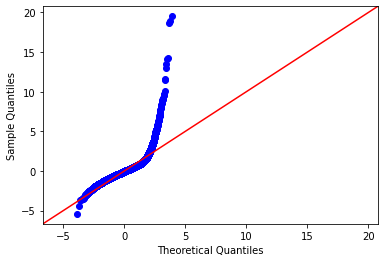

In [60]:
norm_resids(residuals)

## Function of Heteroskedascicity and Auto Correlation

In [61]:
def heteroskd (preds, Y):
    resids = preds - Y
    figure = sns.regplot(preds, resids, color='red', 
                       line_kws={'color':'blue'}, 
                       scatter_kws={'alpha':.5});
    return figure

In [62]:
heteroskd(preds, Y);

NameError: name 'Y' is not defined

## Function for Linear Rainbow Test

In [63]:
def rainbow(results):
    fstat, pvalue = sm.stats.diagnostic.linear_rainbow(results)
    return f'P-value of linearity: {pvalue}'

In [64]:
rainbow(results)

'P-value of linearity: 2.467415663044872e-09'

## Function for idenfying outliers and number of outliers

In [65]:
def outliers(df, column):
    Q1 = df[column].quantile(.25)
    Q3 = df[column].quantile(.75)
    IQR = Q3 - Q1
    lower_lim = Q1 - 1.5 * IQR
    upper_lim = Q3 + 1.5 * IQR
    
    return lower_lim, upper_lim

In [66]:
def outlier_count(column):
    high_o = (df[column] > outliers(column)[1]).sum()
    low_o = (df[column] < outliers(column)[0]).sum()
    return high_o, low_o

In [67]:
outliers(df_country, 'sqft_living')

(-295.0, 4645.0)

<AxesSubplot:xlabel='sqft_living', ylabel='Density'>

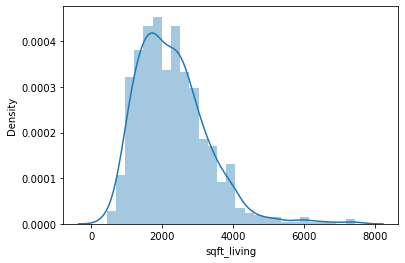

In [68]:
sns.distplot(df_country['sqft_living'])

# Models for Seattle and Country Areas

In [69]:
X_seattle1 = sm.add_constant(df_seattle[['sqft_living','grade','age', 'bathrooms']])
y_seattle1 = df_seattle['price']
X_country1 = sm.add_constant(df_country[['sqft_living','grade','age', 'bathrooms']])
y_country1 = df_country['price']
base_model_seattle = sm.OLS(y_seattle1, X_seattle1)
base_model_country = sm.OLS(y_country1, X_country1)
test_results_seattle = base_model_seattle.fit()
test_results_country = base_model_country.fit()

'P-value of linearity: 0.8629425388523324'

,VIF,feature
0,94.128933,const
1,3.972789,sqft_living
2,3.164854,grade
3,1.927620,age
4,3.784014,bathrooms


<AxesSubplot:ylabel='price'>

None

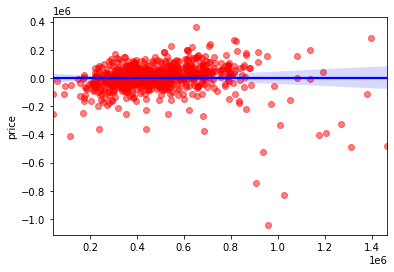

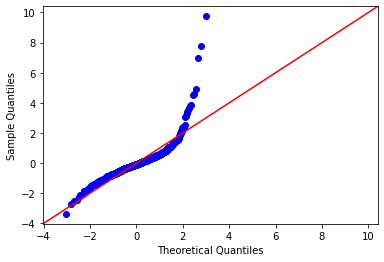

In [70]:
check_model(base_model_country, X_country1, y_country1)

In [71]:
check_model(model_seattle, X_seattle, y_seattle)

NameError: name 'model_seattle' is not defined

# Creating more specific data

## Function for dropping outliers

In [ ]:
def df_no_outliers(data, column):
    outlier_low = (data[column] < outliers(data, column)[0])
    outlier_high = (data[column] > outliers(data, column)[1])
    return data[column][~(outlier_low | outlier_high)]

## Creating new dataframes without outliers

In [72]:
df_seattle_no_outliers = df_seattle

In [73]:
df_seattle_no_outliers['bathrooms'] = df_no_outliers(df_seattle, 'bathrooms')
df_seattle_no_outliers['sqft_living'] = df_no_outliers(df_seattle, 'sqft_living')
df_country_no_outliers['grade'] = df_no_outliers(df_country, 'grade')
df_seattle_no_outliers['waterfront'] = df_seattle_no_outliers.waterfront.fillna(0)
df_seattle_no_outliers = df_seattle_no_outliers.dropna()

NameError: name 'df_no_outliers' is not defined

In [74]:
df_country_no_outliers = df_country

In [75]:
df_country_no_outliers['bathrooms'] = df_no_outliers(df_country, 'bathrooms')
df_country_no_outliers['sqft_living'] = df_no_outliers(df_country, 'sqft_living')
df_country_no_outliers['grade'] = df_no_outliers(df_country, 'grade')
df_country_no_outliers['waterfront'] = df_country_no_outliers.waterfront.fillna(0)
df_country_no_outliers = df_country_no_outliers.dropna()

NameError: name 'df_no_outliers' is not defined

In [76]:
df_seattle_no_outliers['sqft_open'] = df_seattle_no_outliers['sqft_lot'] - df_seattle_no_outliers['sqft_living']

In [77]:
df_country_no_outliers['sqft_open'] = df_country_no_outliers['sqft_lot'] - df_country_no_outliers['sqft_living']

## Assessing correlation and creating "bedroom_num"

In [78]:
df_seattle_no_outliers.corr()['price'].map(abs).sort_values()

id                    0.015037
condition             0.036555
age                   0.050393
yr_renovated/built    0.050422
sqft_open             0.070297
sqft_lot              0.088964
renovated             0.120899
has_basement          0.177948
floors                0.255585
waterfront            0.277672
bedrooms              0.306165
bathrooms             0.525253
grade                 0.667837
sqft_living           0.703417
price                 1.000000
region                     NaN
Name: price, dtype: float64

In [79]:
df_country_no_outliers.corr()['price'].map(abs).sort_values()

id                    0.020987
renovated             0.066543
has_basement          0.092367
condition             0.150184
sqft_open             0.372336
sqft_lot              0.378711
floors                0.434012
age                   0.441899
yr_renovated/built    0.443451
bedrooms              0.445249
bathrooms             0.699057
grade                 0.790080
sqft_living           0.858611
price                 1.000000
waterfront                 NaN
region                     NaN
Name: price, dtype: float64

In [80]:
df_country_no_outliers['bathroom_num'] = df_country_no_outliers['bathrooms']*df_country_no_outliers['bedrooms']
df_seattle_no_outliers['bathroom_num'] = df_seattle_no_outliers['bathrooms']*df_seattle_no_outliers['bedrooms']

# Our Finished Models

## Model Creation and Summary

In [81]:
X_seattle = sm.add_constant(df_seattle_no_outliers[['sqft_living', 'grade', 'has_basement', 'waterfront', 'bathrooms']])
y_seattle = np.log(df_seattle_no_outliers['price'])
seattle_model = sm.OLS(y_seattle, X_seattle)
seattle_results = seattle_model.fit()

MissingDataError: exog contains inf or nans

In [82]:
X_country = sm.add_constant(df_country_no_outliers[['sqft_living','grade', 'has_basement']])
y_country = df_country_no_outliers['price']
country_model = sm.OLS(y_country, X_country)
country_results = country_model.fit()

In [83]:
country_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.774
Model:                            OLS   Adj. R-squared:                  0.774
Method:                 Least Squares   F-statistic:                     901.9
Date:                Wed, 30 Jun 2021   Prob (F-statistic):          2.96e-254
Time:                        09:45:43   Log-Likelihood:                -10290.
No. Observations:                 792   AIC:                         2.059e+04
Df Residuals:                     788   BIC:                         2.061e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const         -2.14e+05   2.87e+04     -7.446      0.000    -2.7e+05   -1.58e+05
sqft_living    148.3033      6.478     22.894      0.000     135.588     161.019
grade         4.826e+04   5071.593      9.516      0.000    3.83e+04    5.82e+04
has_basement -5.139e+04   1.05e+04     -4.880      0.000   -7.21e+04   -3.07e+04
==============================================================================
Omnibus:                      594.781   Durbin-Watson:                   1.980
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            16392.397
Skew:                           3.086   Prob(JB):                         0.00
Kurtosis:                      24.416   Cond. No.                     1.92e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.92e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## Checking Assumptions for model

In [84]:
check_model(seattle_model, X_seattle, y_seattle)

NameError: name 'seattle_model' is not defined

'P-value of linearity: 0.8995286352237062'

,VIF,feature
0,57.704271,const
1,2.930604,sqft_living
2,2.805443,grade
3,1.076493,has_basement


<AxesSubplot:ylabel='price'>

None

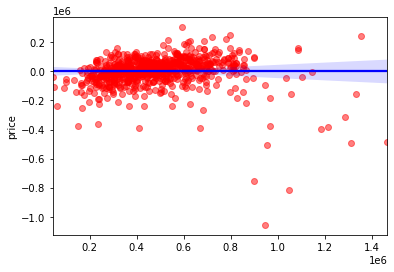

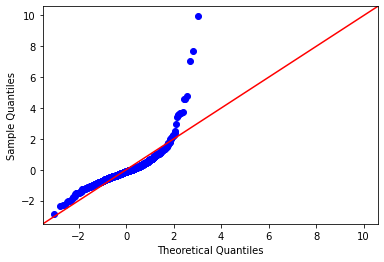

In [85]:
check_model(country_model, X_country, y_country)

# Creating Visuals

## Bar Plot for grade and mean price

In [ ]:
test = pd.DataFrame(df_seattle_no_outliers.groupby('grade').mean()['price'])
test['index'] = range(10)
test.set_index('index', inplace=True)
test['grade'] = [3,4,5,6,7,8,9,10,11,12]

In [ ]:
fig, ax = plt.subplots(figsize=(10,7))
sns.barplot(data = test, x='grade', y='price');

# Reports

## Seattle Model Report

#### Overview
Our model using data from within the city of Seattle was created to infer how potential factors affected the selling prices of homes within that specified area. By modeling multiple independent variables in relation to price, we narrowed down the truly significant factors to be the house's square footage (sqft_living), the number of bathrooms per bedroom (bathrooms), whether it had a basement or not (has_basement),  whether it had a waterfront view or not (waterfront), and the overall grade of the house as defined by the King County grading system (grade). The goal of our model was to provide an accurate change in sales price in respect to changing each one of those variables.
- Note: sqft_living correspondes with the square footage of the structure, not the square footage of the lot or property

The pricing of the homes was log-transformed to more cleanly fit with our model. By doing so, it passed the assumptions neccesary for providing inference. 

#### Interpreting the Model
The coefficients associated with our model represent the proportion at which the sales price changes, given that the independent variable increased by 1 unit. 

The coefficient for sqft_living is **0.0002**, which means for every 1 sqft increase in house area, the price of that home goes up by 0.02%. While this may seem small, square footage increases multiplicitly rate when expanding the length and width of a house; adding 10 feet to the width and 10 feet to the length of a house results in 100 additional sqft. 

The coefficient for grade is **0.2039**. This means that increasing the grade of the house by 1 increases the price by roughly 20.4%.

The coefficient for ratio of bathrooms is **-0.0342**. This means that by increasing the ratio of bathrooms to bedrooms by 1, the price *decreases* by 3.42%. For example, if you have 2 bathrooms for every bedroom, and increase that number to 3 bathrooms per bedroom, you will lower the value of the home.

The coefficient for has_basement is **0.1303**. This means that adding a basement to your home would increase the price by 13.03%.

The coefficient for waterfront is **0.6208**. This means that by having a waterfront view, the value of your home goes up by 62.08%.
- While adding a waterfront view is impossible for some homes, this metric applies to houses with *potential* waterfront views that do not utilize them. If you have a veiw of the water that is blocked, it would behoove you to remove that obstruction.